# Week 2

This notebook examines preprocessing of a text _T_ for matching against pattern _P_

What is not examined in this notebook is the Boyer-Moore algorithm, which is explored as stand-alone, buildable executables from C and C++. It is neat to see that Boyer-Moore is built into C++17 by default and the C implementation is not too hard either.

In [12]:
%matplotlib inline

In [220]:
import bisect
from pathlib import Path
from collections import Counter
import unittest

from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# K-mers using Sorted Container

In [200]:
class IndexKmer:
    """Preprocess text for comparison using an ordered list indexer"""

    def __init__(self, text: str, size: int) -> None:
        """Initialize the k-mer indexer

        Parameters
        ----------
        text : str
            Text to run queries against
        size : int
            Length of the k-mer to index
        """
        self.size = size
        self.text = text
        self.indices: list[tuple[str, int]] = []
        for index in range(len(text) - size + 1):
            self.indices.append(
                (text[index: index + size], index)
            )
        self.indices.sort()

    def query(self, pat: str) -> list[int]:
        """Run a query of the given pattern

        Parameters
        ----------
        pat : str
            Pattern

        Returns
        -------
        list[int]
            All starting offsets for the pattern
        """
        all_hits = self._query_all(pat)
        offsets: list[int] = []
        # Run verification
        for hit in all_hits:
            if pat[self.size:] == self.text[hit + self.size: hit + len(pat)]:
                offsets.append(hit)
        return offsets

    def _query_all(self, pat: str) -> list[int]:
        """Run a query of the given pattern WITHOUT verification

        Parameters
        ----------
        pat : str
            Pattern
        Returns
        -------
        list[int]
            All starting offsets for the pattern
        """
        kmer = pat[:self.size]
        # -1 always returns the first occurrence of pat_kmer
        index = bisect.bisect_left(self.indices, (kmer, -1))
        hits: list[int] = []
        while index < len(self.indices):
            if kmer != self.indices[index][0]:
                break
            hits.append(self.indices[index][1])
            index += 1
        return hits


Run a unit test

In [221]:
class IndexKmerUnitTest(unittest.TestCase):

    def test_all_hits(self):
        text_indexed = IndexKmer("AAAGGGCCCGGGTTT", 2)
        self.assertListEqual(text_indexed.query("GGG"), [3, 9])


res = unittest.main(argv=[''], verbosity=3, exit=False)
assert len(res.result.failures) == 0

test_all_hits (__main__.IndexKmerUnitTest) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


Let's examine the properties of a k-mer against an available genome.

In [9]:
with Path("week1hw/lambda_virus.fa").open(mode="r") as fh:
    lambda_genome = list(SeqIO.parse(fh, "fasta"))[0]

In [192]:
lambda_indexer = IndexKmer(str(lambda_genome.seq), 6)

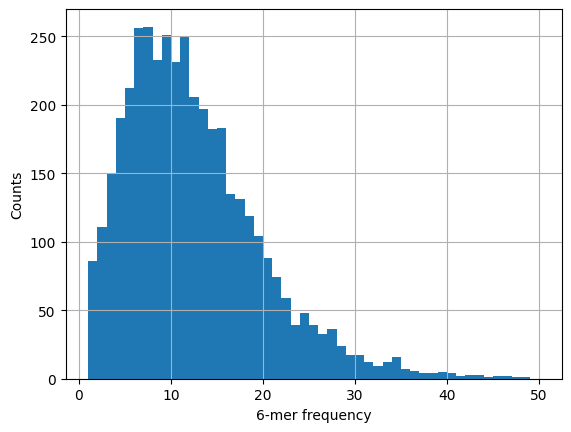

In [217]:
# First count the k-mers
kmer_counter = Counter(
    kmer_index[0]
    for kmer_index in lambda_indexer.indices
)

fig_kmer_counter, ax_kmer_counter = plt.subplots()
ax_kmer_counter: plt.Axes
ax_kmer_counter.hist(
    list(kmer_counter.values()),
    bins=np.arange(1, 51, 1)
)
ax_kmer_counter.set_xlabel(f"{lambda_indexer.size}-mer frequency")
ax_kmer_counter.set_ylabel("Counts")
ax_kmer_counter.grid(True)
plt.show(fig_kmer_counter)

This is an interesting shape. Can we characterize the shape? After some trail-and-error, I believe the frequency of k-mers follows a Cauchy distribution with a Gaussian

In [213]:
def fit_fcn(x: np.ndarray, *args):
    """A Cauchy distribution with a Gaussian"""
    amp, loc, scale = args
    return amp * scale**2 / ((np.power(x - loc, 2)) + scale**2) * np.exp(-np.power(x - loc, 2) / (2 * scale**2))

In [214]:
kmer_counter2 = Counter(kmer_counter.values())

xdata = np.array(list(kmer_counter2.keys()))
ydata = np.array(list(kmer_counter2.values()))
kmer_fit = curve_fit(
    fit_fcn,
    xdata,
    ydata,
    p0=(np.max(ydata), 10.0, 10.0),
    bounds=[
        (0.5 * np.max(ydata), -50., 1.),
        (2.0 * np.max(ydata), 50., 1000)
    ],
)

kmer_fit

(array([247.016234  ,   9.2952436 ,  11.16814453]),
 array([[ 2.21962745e+01,  1.00991638e-01, -9.63731122e-01],
        [ 1.00991638e-01,  2.98218997e-02, -1.76441134e-02],
        [-9.63731122e-01, -1.76441134e-02,  1.07020613e-01]]))

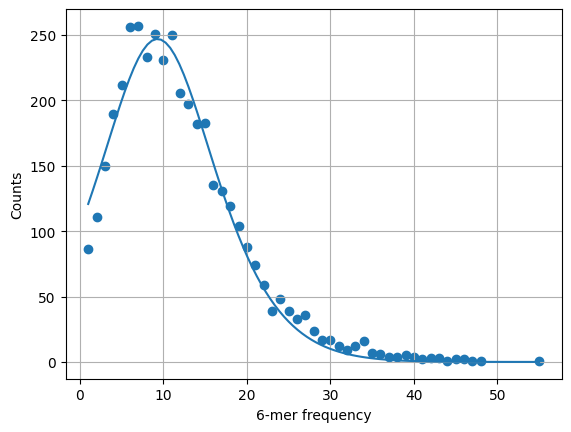

In [216]:
fig_fit_fcn, ax_fit_fcn = plt.subplots()

x_linear = np.linspace(
    np.min(xdata),
    np.max(xdata),
    num=100
)
ax_fit_fcn.plot(
    x_linear,
    fit_fcn(x_linear, *tuple(kmer_fit[0])),
)
ax_fit_fcn.scatter(
    xdata,
    ydata
)

ax_fit_fcn.set_xlabel(f"{lambda_indexer.size}-mer frequency")
ax_fit_fcn.set_ylabel("Counts")
ax_fit_fcn.grid(True)
plt.show(fig_fit_fcn)